In [1]:
%matplotlib widget
import os
import io
import re
import pickle
import gridfs
import pymongo
import numpy as np
import pandas as pd
from PIL import Image
from pprint import pprint
from pymongo import MongoClient
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
# from IPython.display import Image
from collections import OrderedDict
import matplotlib.widgets as widgets
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

In [2]:
# Conenct to the client
client = MongoClient('localhost', 27017)

# List databases, collections, and select from them

In [3]:
# client.drop_database('sacred_mnist_example') # delete database
# client.drop_database('hyperopt') # delete database
print('databases:', client.list_database_names())

databases: ['MY_DB', 'admin', 'config', 'local']


In [4]:
db = client['MY_DB']
print('Collections of {} db: {}'.format(db.name, db.list_collection_names()))

Collections of MY_DB db: ['runs', 'omniboard.columns', 'fs.files', 'metrics', 'fs.chunks']


# Example of a record (a "document") for a single experiment

In [ ]:
exp = list(db.runs.find())[-1]
pprint(exp.keys())
pprint('Example of a "document" that represents a single experiment:')
pprint('\n\n Example of configurations of several experiemts:')
pprint(exp)

# Example of configuration of several experiments

In [ ]:
print('Example of configurations of several experiments:\n')
for i, exp in enumerate(list(db.runs.find())[0:3]):
    pprint(exp['config'])
    print('')

# Pandas + SACRED
## Get a dataframe that summarize the experiements, according to a PANDAS query

In [5]:
def slice_dict(d, keys):
    """ Returns a dictionary ordered and sliced by given keys
        keys can be a list, or a CSV string
    """
    if isinstance(keys, str):
        keys = keys[:-1] if keys[-1] == ',' else keys
        keys = re.split(', |[, ]', keys)

    return dict((k, d[k]) for k in keys)

def sacred_to_df(db_runs, mongo_query=None, ):
    """
    db_runs is usually db.runs
    returns a dataframe that summarizes the experiments, where 
    config and info fields are flattened to their keys.
    Summary DF contains the following columns:
    _id, experiment.name, **config, result, **info, status, start_time
    """
    # get all experiment according to mongo query and represent as a pandas DataFrame    
    df = pd.DataFrame(list(db_runs.find(mongo_query)))

    # Take only the interesting columns
    df = df.loc[:, '_id, experiment, config, result, info, status, start_time'.split(', ')]
#     import pdb; pdb.set_trace()
#     df = df.loc[:, ['_id', 'experiment', 'info', 'status', 'start_time']]

    def _summerize_experiment(s):
        """
        Take only the 
        """
        o = OrderedDict()
        o['_id'] = s['_id']
        o['name'] = s['experiment']['name']
        o.update(s['config'])
        for key, val in s['info'].items():
            if key != 'metrics':
                o[key] = val 

        o.update(slice_dict(s.to_dict(), 'info, status'))
        return pd.Series(o)
    
    sum_list = []
    for ix, s in df.iterrows():
        sum_list.append(_summerize_experiment(s))
    df_summary = pd.DataFrame(sum_list).set_index('_id')
    
    return df_summary

# Filter according to some query

In [6]:
# Get the COMPLETED experiments with dim<=100 and val. accuracy > 85%
query = "status == 'COMPLETED'"
df_summary = sacred_to_df(db.runs)
# Fix column names
df_summary.columns = df_summary.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_summary.columns = df_summary.columns.str.replace('.', '_')
# Now execute the query
df_summary.query(query)
# Sort them in ascending order based on validation loss (best performer is first).
df_summary = df_summary.sort_values('best_valid_loss', ascending=True)
# display(slice_dict(df_summary, 'experiment, result'))
display(df_summary)

,name,default_params,seed,best_valid_loss,ckpt,info,status
_id,,,,,,,
43,circles_scatter_weights_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",196231595,2.070855e-07,./models//circles/scatter_weights/epoch_499_lo...,"{'best.valid.loss': 2.070855202873645e-07, 'ck...",COMPLETED
60,moons_vanilla_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",547989329,2.537913e-07,./models//moons/vanilla/epoch_499_loss_[0. 0. ...,"{'best.valid.loss': 2.537913132982794e-07, 'ck...",COMPLETED
41,circles_vanilla_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",783968949,3.607927e-07,./models//circles/vanilla/epoch_434_loss_[0. 0...,"{'best.valid.loss': 3.6079273968425696e-07, 'c...",COMPLETED
62,moons_scatter_weights_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",964110128,1.508898e-06,./models//moons/scatter_weights/epoch_499_loss...,"{'best.valid.loss': 1.508897867097403e-06, 'ck...",COMPLETED
44,circles_scatter_embedding_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",10716314,2.795730e-05,./models//circles/scatter_embedding/epoch_497_...,"{'best.valid.loss': 2.795730142679531e-05, 'ck...",COMPLETED
63,moons_scatter_embedding_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",857679529,8.296079e-05,./models//moons/scatter_embedding/epoch_499_lo...,"{'best.valid.loss': 8.296078885905445e-05, 'ck...",COMPLETED
42,circles_l2_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",896056495,1.296618e-04,./models//circles/l2/epoch_499_loss_[0.0001290...,"{'best.valid.loss': 0.00012966181384399533, 'c...",COMPLETED
61,moons_l2_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",155928640,2.170201e-04,./models//moons/l2/epoch_499_loss_[0.00021039 ...,"{'best.valid.loss': 0.0002170201187254861, 'ck...",COMPLETED
66,swiss_roll_scatter_weights_AdamOptimizer,"{'appconfig': {'data_dir': 'data/raw/', 'log_d...",808639700,1.401644e-03,./models//swiss_roll/scatter_weights/epoch_497...,"{'best.valid.loss': 0.00140164396725595, 'ckpt...",COMPLETED


# Get raw experiments, according to the summary dataframe

In [7]:
def query_by_df(mongo_db_runs, df=None, ids=None):
    """
    Get raw experiments, according to the summary dataframe, or list of ids
    """
    if ids is None:
        ids = df.index.tolist()
        
    # Get a mongo iterator, according to the pandas DataFrame. 
    mongo_cursor = mongo_db_runs.find(dict(_id={'$in':ids}))
    
    # put raw results to a datafram
    df_raw_results = pd.DataFrame(list(mongo_cursor)).set_index('_id')
    
    # reorder results according to given dataframe because Cursor iterator does not preserve order from given dataframe 
    df_raw_results = df_raw_results.reindex(ids)
    return df_raw_results

# Show raw experiments artifacts

In [8]:
df_raw = query_by_df(db.runs, df_summary)
# show the results of the 'artifacts' field (resulting files)
# display(df_raw.artifacts)
# the dataframe that holds the raw experiments information
# df_raw.head()
display(df_raw)

,artifacts,captured_out,command,config,experiment,format,heartbeat,host,info,meta,resources,result,start_time,status,stop_time
_id,,,,,,,,,,,,,,,
43,"[{'name': 'scatter_plot.png', 'file_id': 5c71c...",INFO - circles_scatter_weights_AdamOptimizer -...,main,{'default_params': {'appconfig': {'data_dir': ...,{'name': 'circles_scatter_weights_AdamOptimize...,MongoObserver-0.7.0,2019-02-23 22:46:32.196,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 2.070855202873645e-07, 'ck...","{'command': 'main', 'options': {'--force': Fal...",[],None,2019-02-23 22:43:10.285,COMPLETED,2019-02-23 22:46:32.174
60,"[{'name': 'scatter_plot.png', 'file_id': 5c731...",INFO - moons_vanilla_AdamOptimizer - Running c...,main,{'default_params': {'appconfig': {'data_dir': ...,"{'name': 'moons_vanilla_AdamOptimizer', 'base_...",MongoObserver-0.7.0,2019-02-24 22:26:23.779,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 2.537913132982794e-07, 'ck...","{'command': 'main', 'options': {'--capture': N...",[],None,2019-02-24 22:23:02.012,COMPLETED,2019-02-24 22:26:23.760
41,"[{'name': 'scatter_plot.png', 'file_id': 5c71c...",INFO - circles_vanilla_AdamOptimizer - Running...,main,{'default_params': {'appconfig': {'data_dir': ...,"{'name': 'circles_vanilla_AdamOptimizer', 'bas...",MongoObserver-0.7.0,2019-02-23 22:39:47.637,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 3.6079273968425696e-07, 'c...","{'command': 'main', 'options': {'--force': Fal...",[],None,2019-02-23 22:36:31.030,COMPLETED,2019-02-23 22:39:47.619
62,"[{'name': 'scatter_plot.png', 'file_id': 5c731...",INFO - moons_scatter_weights_AdamOptimizer - R...,main,{'default_params': {'appconfig': {'data_dir': ...,{'name': 'moons_scatter_weights_AdamOptimizer'...,MongoObserver-0.7.0,2019-02-24 22:33:03.699,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 1.508897867097403e-06, 'ck...","{'command': 'main', 'options': {'--capture': N...",[],None,2019-02-24 22:29:47.945,COMPLETED,2019-02-24 22:33:03.677
44,"[{'name': 'scatter_plot.png', 'file_id': 5c71c...",INFO - circles_scatter_embedding_AdamOptimizer...,main,{'default_params': {'appconfig': {'data_dir': ...,{'name': 'circles_scatter_embedding_AdamOptimi...,MongoObserver-0.7.0,2019-02-23 22:49:43.249,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 2.795730142679531e-05, 'ck...","{'command': 'main', 'options': {'--force': Fal...",[],None,2019-02-23 22:46:32.711,COMPLETED,2019-02-23 22:49:43.228
63,"[{'name': 'scatter_plot.png', 'file_id': 5c731...",INFO - moons_scatter_embedding_AdamOptimizer -...,main,{'default_params': {'appconfig': {'data_dir': ...,{'name': 'moons_scatter_embedding_AdamOptimize...,MongoObserver-0.7.0,2019-02-24 22:36:19.207,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 8.296078885905445e-05, 'ck...","{'command': 'main', 'options': {'--capture': N...",[],None,2019-02-24 22:33:04.199,COMPLETED,2019-02-24 22:36:19.185
42,"[{'name': 'scatter_plot.png', 'file_id': 5c71c...",INFO - circles_l2_AdamOptimizer - Running comm...,main,{'default_params': {'appconfig': {'data_dir': ...,"{'name': 'circles_l2_AdamOptimizer', 'base_dir...",MongoObserver-0.7.0,2019-02-23 22:43:09.772,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 0.00012966181384399533, 'c...","{'command': 'main', 'options': {'--force': Fal...",[],None,2019-02-23 22:39:48.144,COMPLETED,2019-02-23 22:43:09.751
61,"[{'name': 'scatter_plot.png', 'file_id': 5c731...",INFO - moons_l2_AdamOptimizer - Running comman...,main,{'default_params': {'appconfig': {'data_dir': ...,"{'name': 'moons_l2_AdamOptimizer', 'base_dir':...",MongoObserver-0.7.0,2019-02-24 22:29:47.506,"{'hostname': 'fermi', 'os': ['Linux', 'Linux-4...","{'best.valid.loss': 0.0002170201187254861, 'ck...","{'command': 'main', 'options': {'--capture': N...",[],None,2019-02-24 22:26:24.220,COMPLETED,2019-02-24 22:29:47.485
66,"[{'name': 'scatter_plot.png', 'fil

# Load and evaluate the best model
## load the best model

In [9]:
fs = gridfs.GridFS(db)

def exp_artifacts_to_dict(list_artifacts):
    """ Converts a list of artifacts to a dictionary of {filename:file_id}  """
    d = {}
    for ar in list_artifacts:
        if ar['name'] in d.keys():
            d[ar['name']].append(ar['file_id'])
        else:
            d[ar['name']] = []
            d[ar['name']].append(ar['file_id'])
    return d

# Do not execute

In [ ]:
import mnist_keras
mnist_keras.config_tf_session()

model_fname = 'mnist_model.h5'

# get file_id of best model from the first row in the df_raw DataFrame
gfs_best_model = exp_artifacts_to_dict(df_raw.artifacts.iloc[0])[model_fname]

# Can't load Keras model directly from GridFS. Therefore, we first copy the model 
# to /tmp (on OS filesystem), and then load it from there

# Read the model from GridFS
model_bytes = fs.get(gfs_best_model).read()
# Write the model to the OS filesystem
!mkdir -p /tmp/mnist_model
tmp_model_fname = '/tmp/mnist_model/model.h5'
with open(tmp_model_fname, 'wb') as f:
    f.write(model_bytes)

# Load the model to Keras, from OS filesystem
import tensorflow.keras as keras
model = keras.models.load_model(tmp_model_fname)

# Getting artifacts and plotting scatter matrices

In [ ]:
class Player(FuncAnimation):
    def __init__(self, fig, func, frames=None, init_func=None, fargs=None,
                 save_count=None, mini=0, maxi=100, pos=(0.125, 0.92), **kwargs):
        self.i = 0
        self.min=mini
        self.max=maxi
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        FuncAnimation.__init__(self,self.fig, self.update, frames=self.play(), 
                                           init_func=init_func, fargs=fargs,
                                           save_count=save_count, **kwargs )    

    def play(self):
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i

    def start(self):
        self.runs=True
        self.event_source.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def forward(self, event=None):
        self.forwards = True
        self.start()
    def backward(self, event=None):
        self.forwards = False
        self.start()
    def oneforward(self, event=None):
        self.forwards = True
        self.onestep()
    def onebackward(self, event=None):
        self.forwards = False
        self.onestep()

    def onestep(self):
        if self.i > self.min and self.i < self.max:
            self.i = self.i+self.forwards-(not self.forwards)
        elif self.i == self.min and self.forwards:
            self.i+=1
        elif self.i == self.max and not self.forwards:
            self.i-=1
        self.func(self.i)
        self.slider.set_val(self.i)
        self.fig.canvas.draw_idle()

    def setup(self, pos):
        playerax = self.fig.add_axes([pos[0],pos[1], 0.64, 0.04])
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(playerax)
        bax = divider.append_axes("right", size="80%", pad=0.05)
        sax = divider.append_axes("right", size="80%", pad=0.05)
        fax = divider.append_axes("right", size="80%", pad=0.05)
        ofax = divider.append_axes("right", size="100%", pad=0.05)
        sliderax = divider.append_axes("right", size="500%", pad=0.07)
        self.button_oneback = widgets.Button(playerax, label=u"$\u29CF$")
        self.button_back = widgets.Button(bax, label=u'$\u25C0$')
        self.button_stop = widgets.Button(sax, label=u'$\u25A0$')
        self.button_forward = widgets.Button(fax, label=u'$\u25B6$')
        self.button_oneforward = widgets.Button(ofax, label=u"$\u29D0$")
        self.button_oneback.on_clicked(self.onebackward)
        self.button_back.on_clicked(self.backward)
        self.button_stop.on_clicked(self.stop)
        self.button_forward.on_clicked(self.forward)
        self.button_oneforward.on_clicked(self.oneforward)
        self.slider = widgets.Slider(sliderax, '', self.min, self.max, valinit=self.i)
        self.slider.on_changed(self.set_pos)

    def set_pos(self,i):
        self.i = int(self.slider.val)
        self.func(self.i)

    def update(self,i):
        self.slider.set_val(i)

In [ ]:
exper = {'name': [], 'imgs': []}
for idx, ex in enumerate(df_raw.experiment):
    print(ex['name'])
    gfs_artifacts = exp_artifacts_to_dict(df_raw.artifacts.iloc[idx])['scatter_plot.png']
    imgs_bytes = [fs.get(imgObj).read() for imgObj in gfs_artifacts]
    imgs = [Image.open(io.BytesIO(img)) for img in imgs_bytes]
    exper['name'].append(ex['name'])
    exper['imgs'].append(imgs)    

In [ ]:
idx = 
def update(i):
    obj.set_data(exper['imgs'][idx][i])

fig, ax = plt.subplots()
obj = ax.imshow(np.random.randn(480, 640, 4))
ani = Player(fig, update, maxi=len(exper['imgs'][idx])-1)
plt.title(exper['name'][idx])
plt.axis('off')
plt.show()

# Do we get better calibrated models?

In [64]:
df_calib = pd.DataFrame(exper)

In [73]:
import base64
from IPython.display import HTML

pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with io.BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    
def image_formatter(im):
    return f'<img src="data:image/png;base64,{image_base64(im)}">'

,Model,Before,After
0,circles_scatter_weights_AdamOptimizer,,
1,moons_vanilla_AdamOptimizer,,
2,circles_vanilla_AdamOptimizer,,
3,moons_scatter_weights_AdamOptimizer,,
4,circles_scatter_embedding_AdamOptimizer,,
5,moons_scatter_embedding_AdamOptimizer,,
6,circles_l2_AdamOptimizer,,
7,moons_l2_AdamOptimizer,,
8,swiss_roll_scatter_weights_AdamOptimizer,,
9,swiss_roll_l2_AdamOptimizer,,

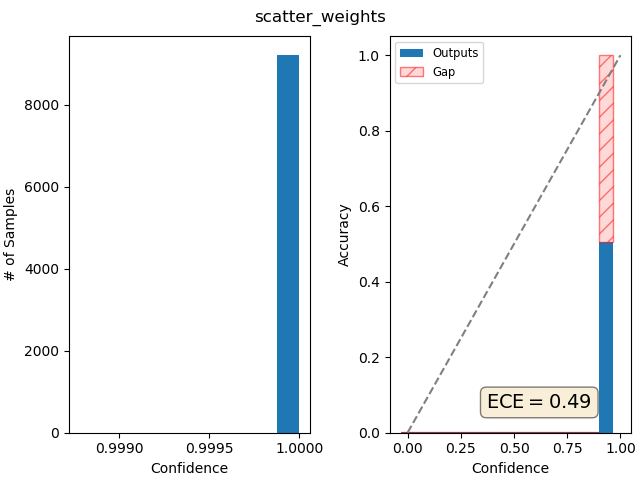
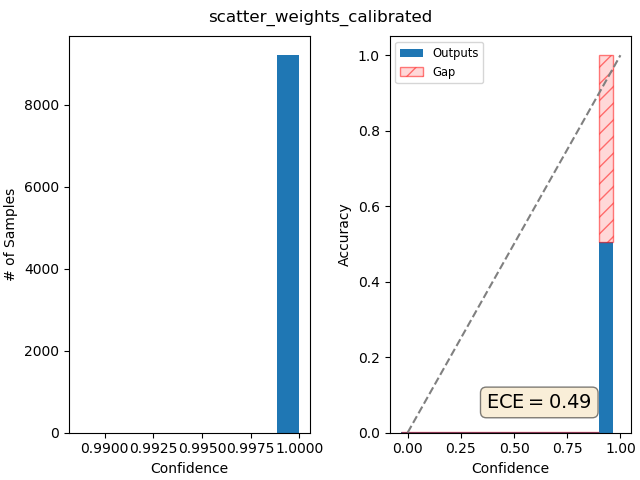
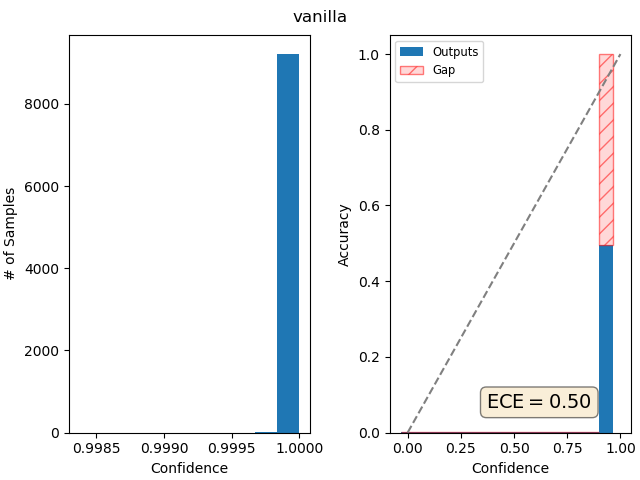
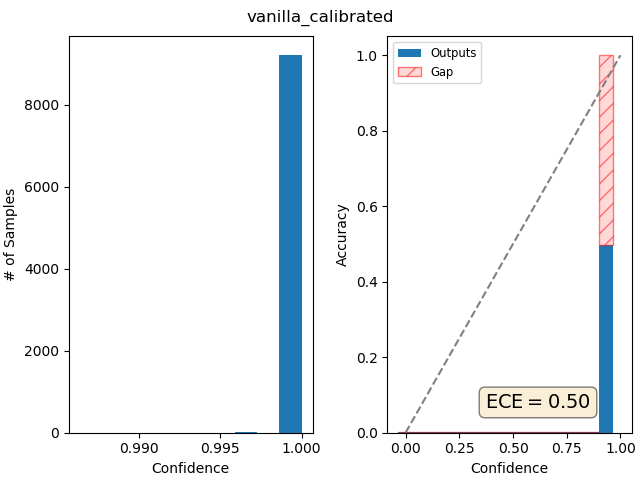
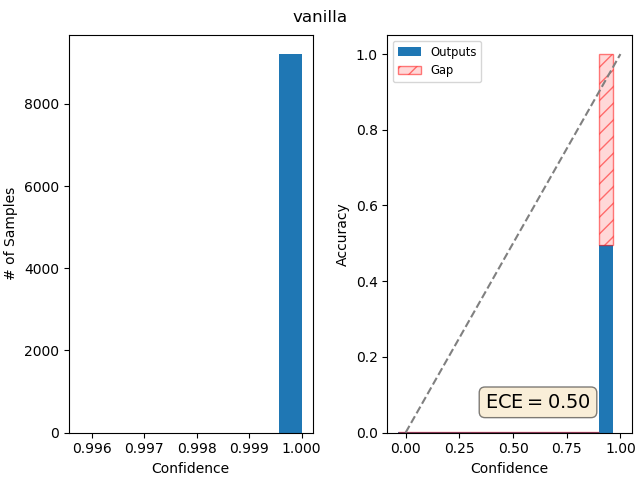
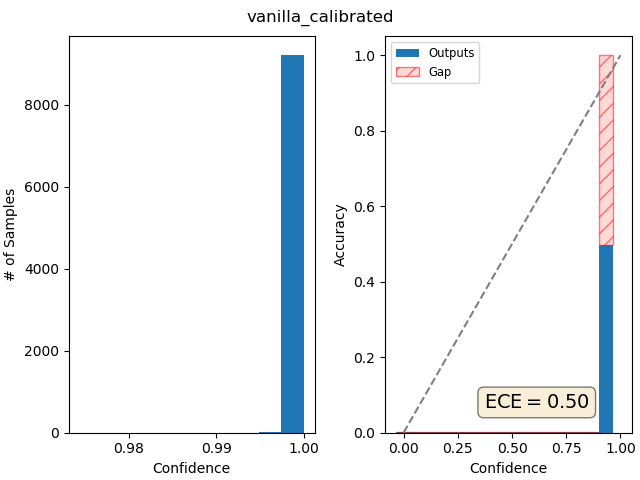
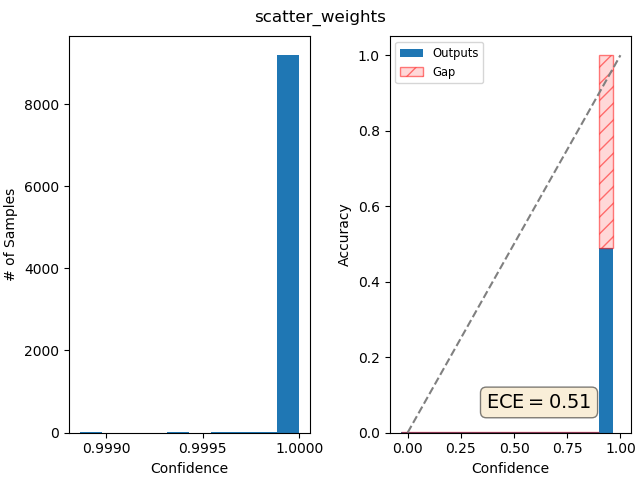
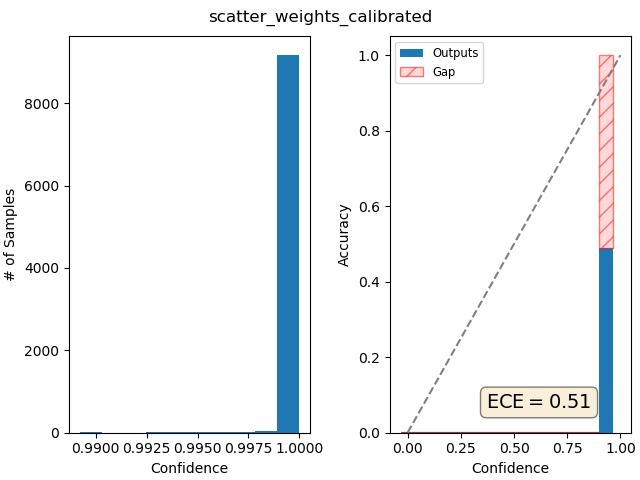
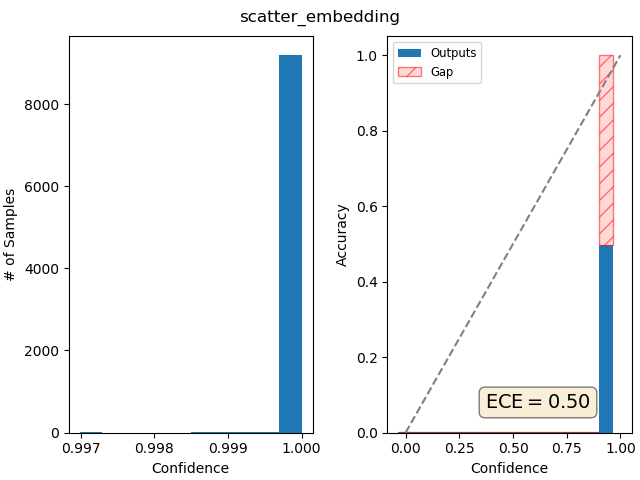
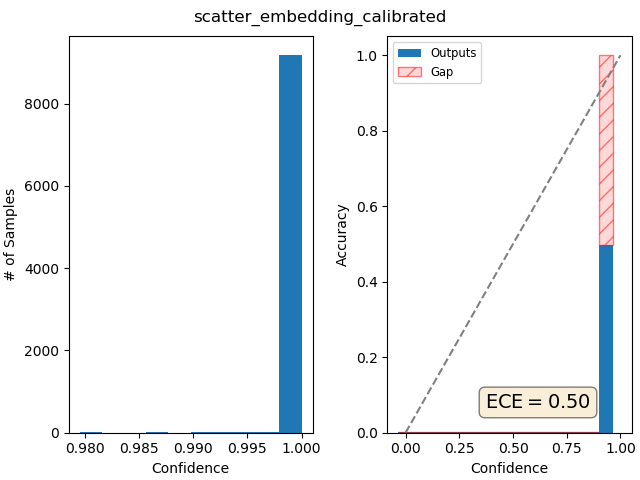
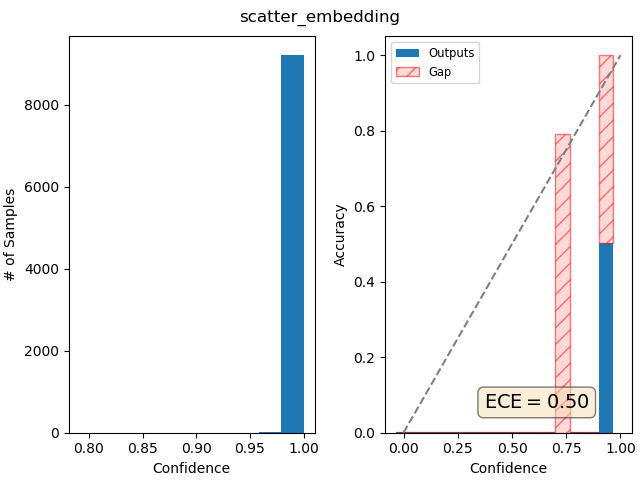
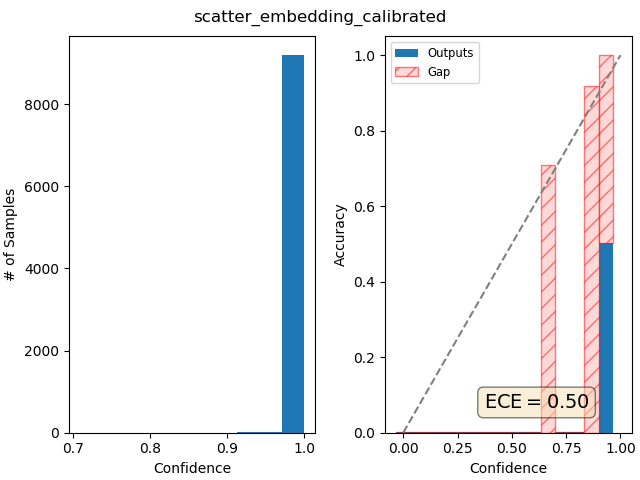
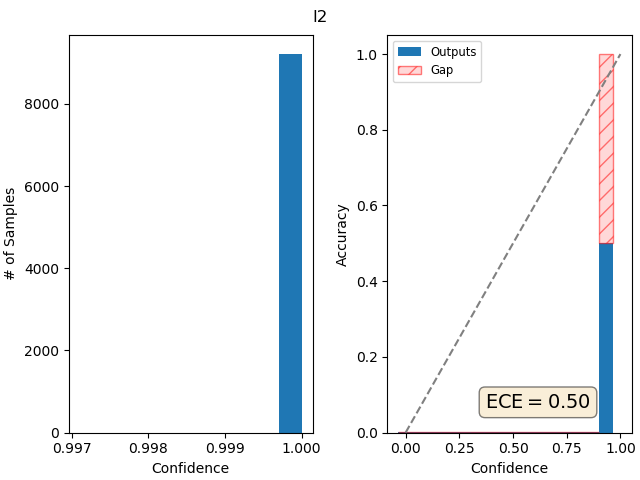
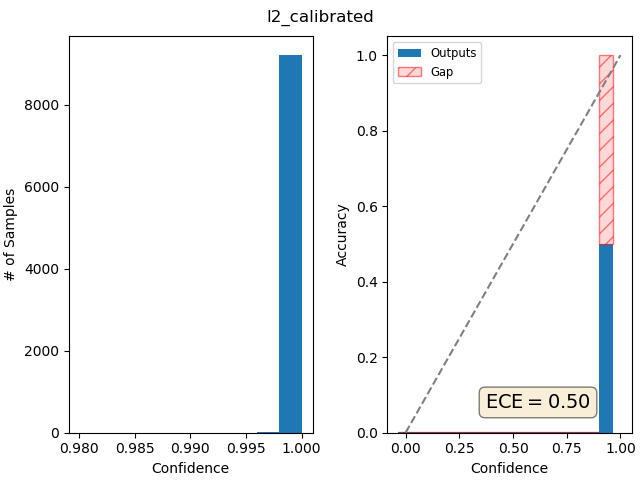
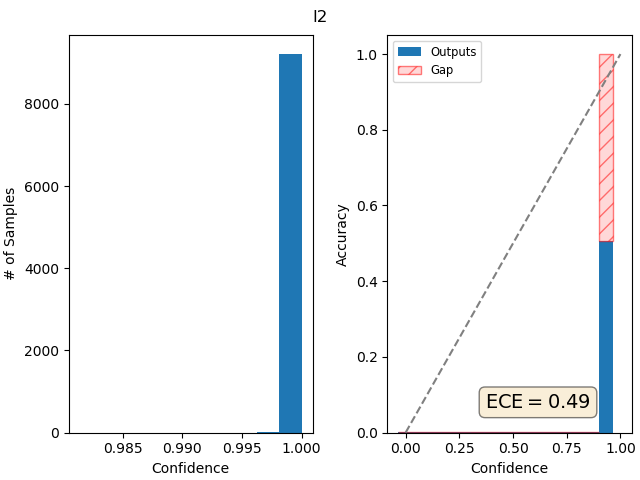
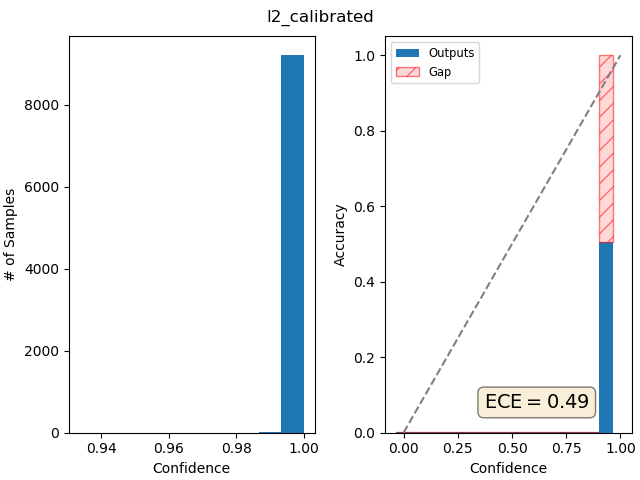
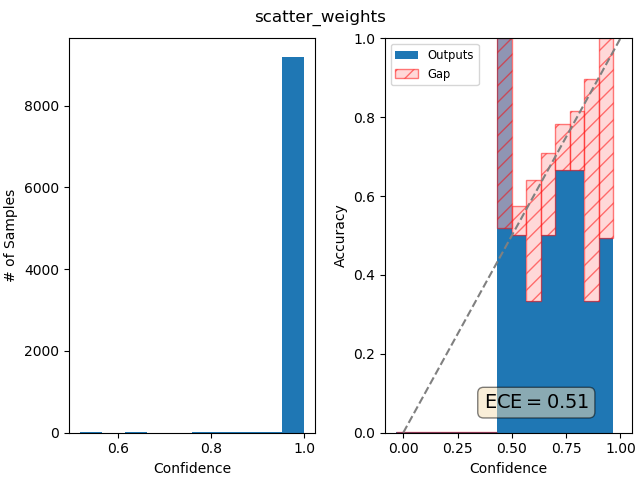
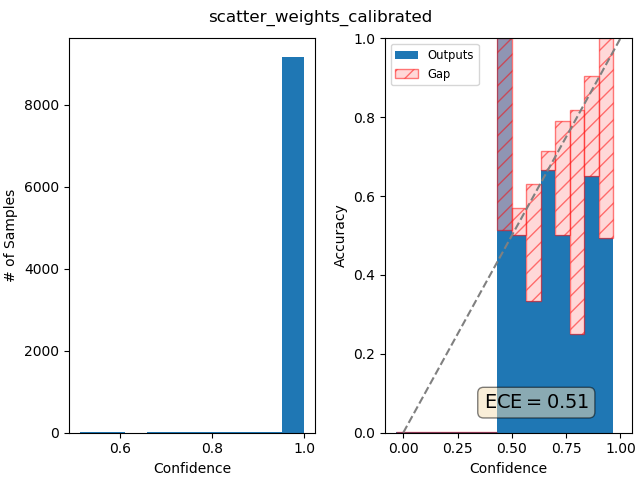
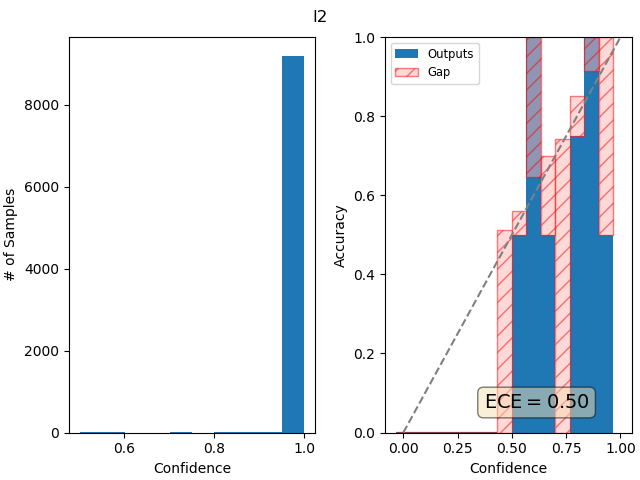
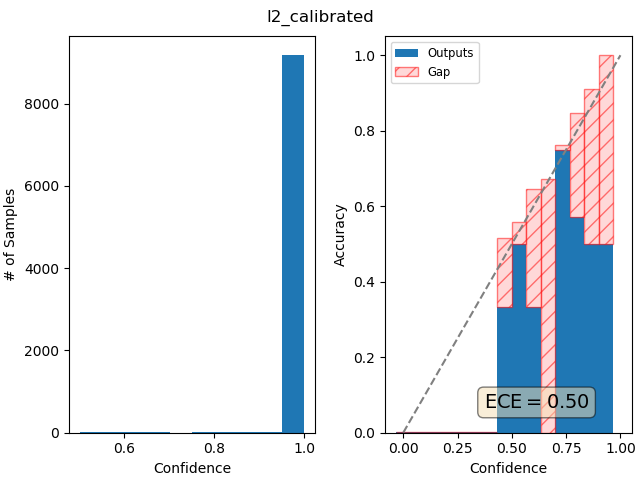
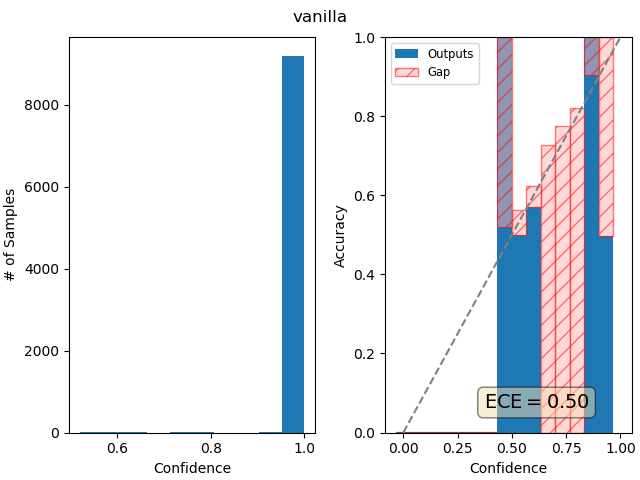
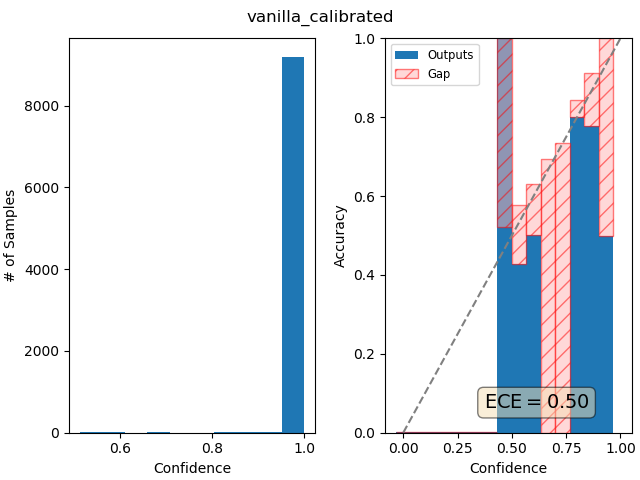
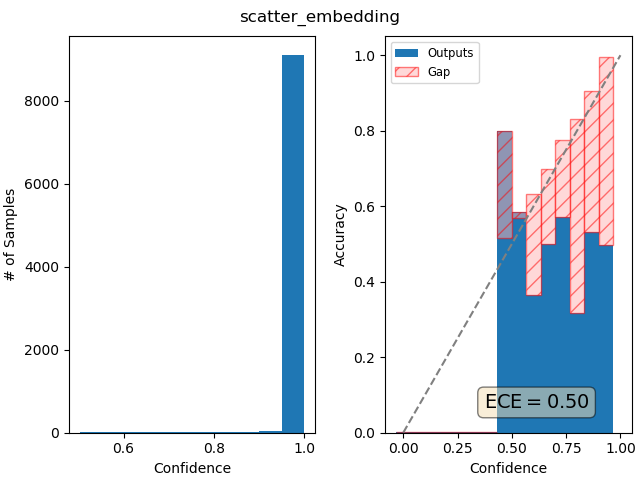
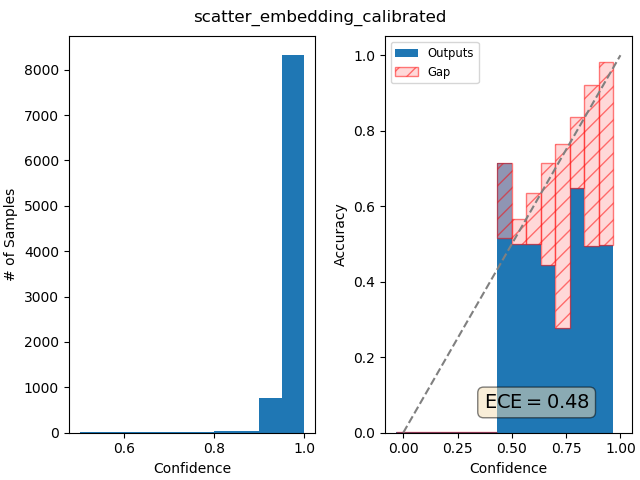
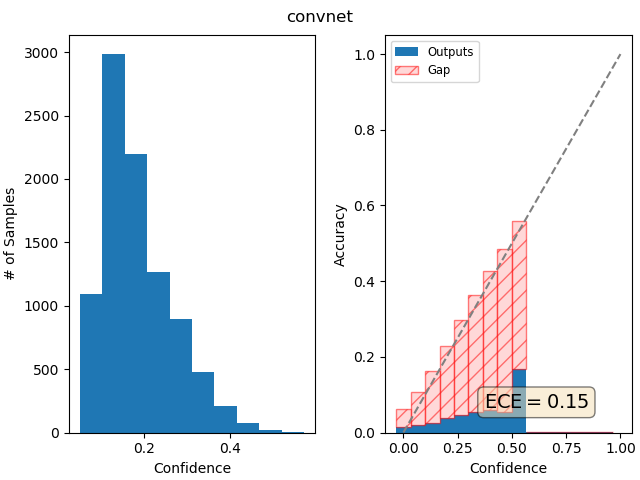
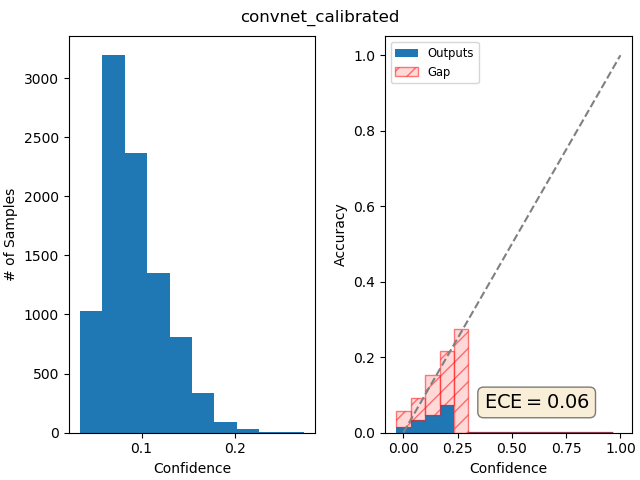
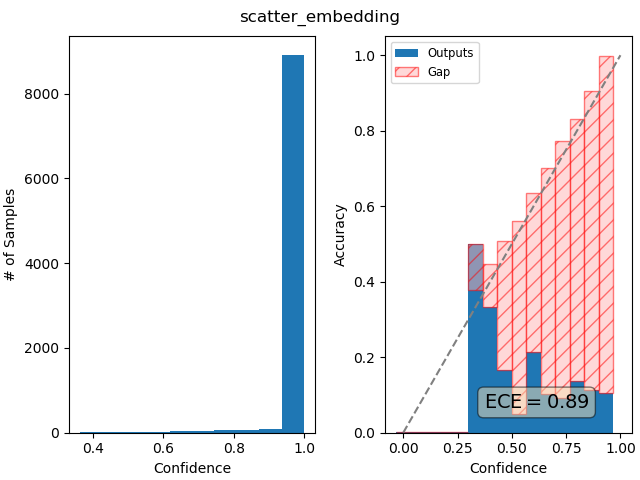
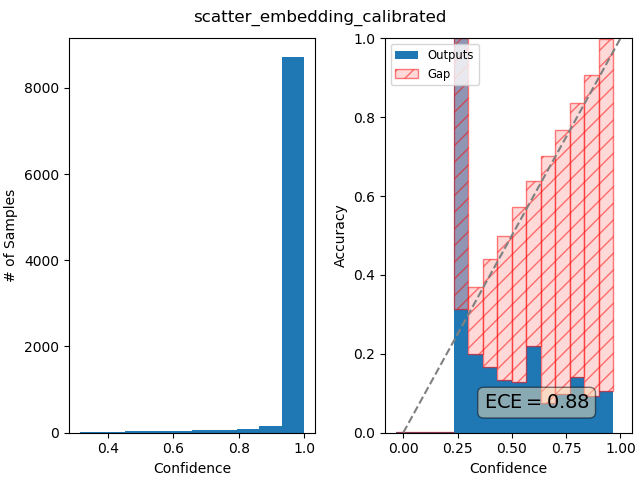
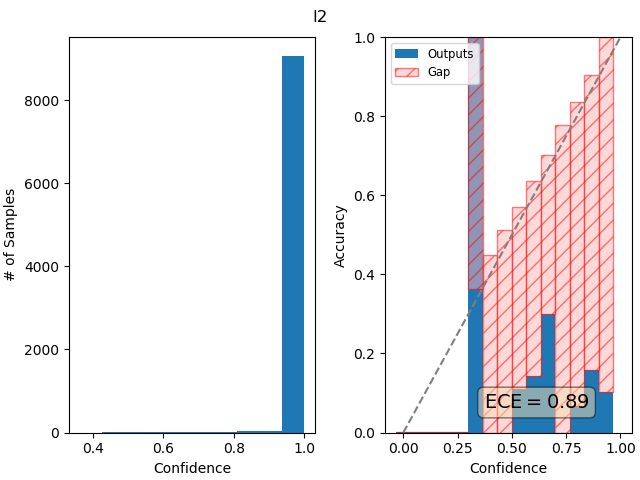
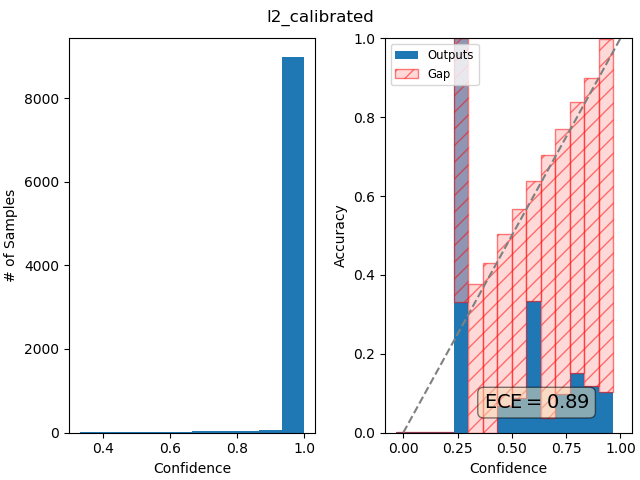
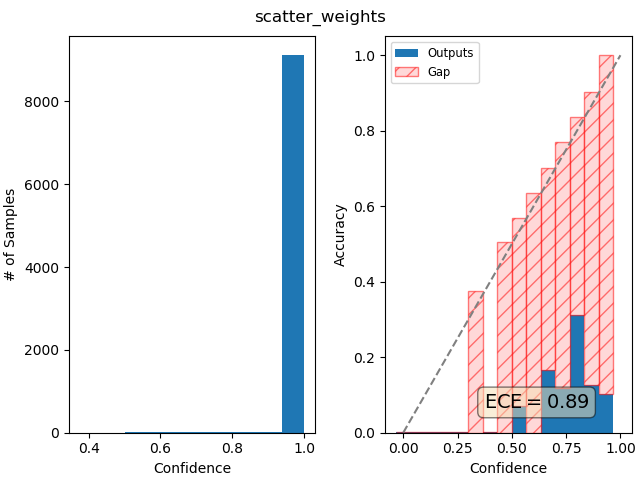
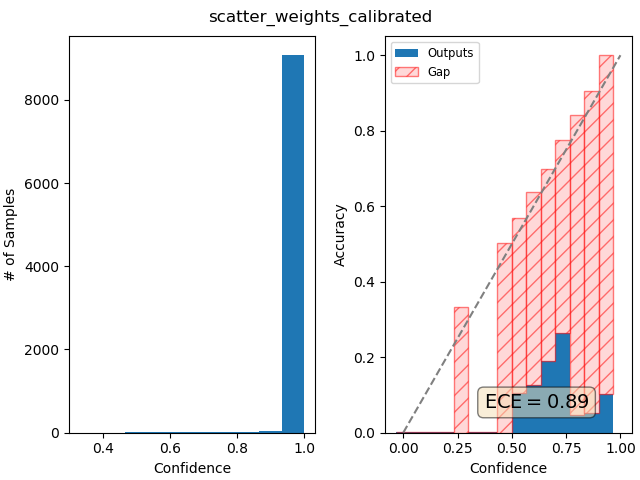
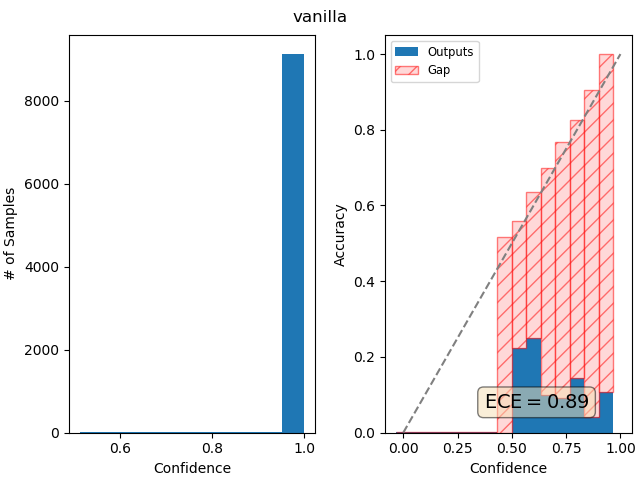
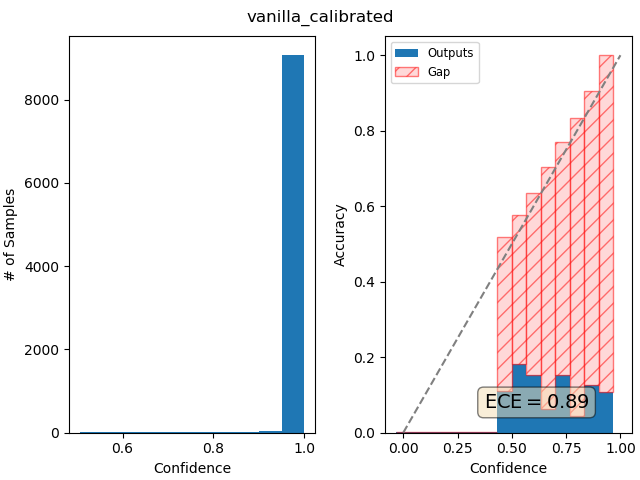
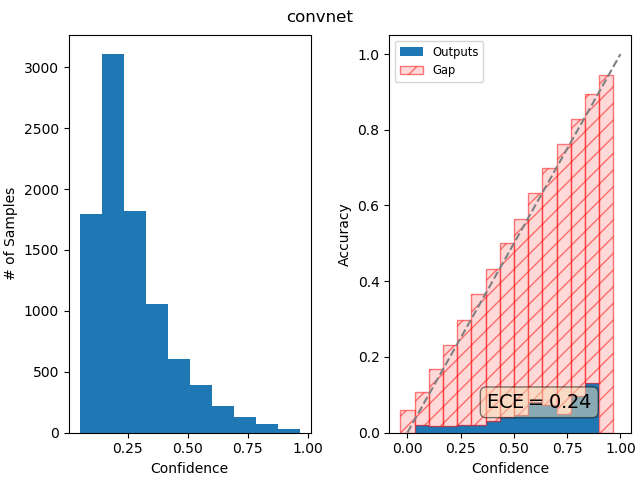
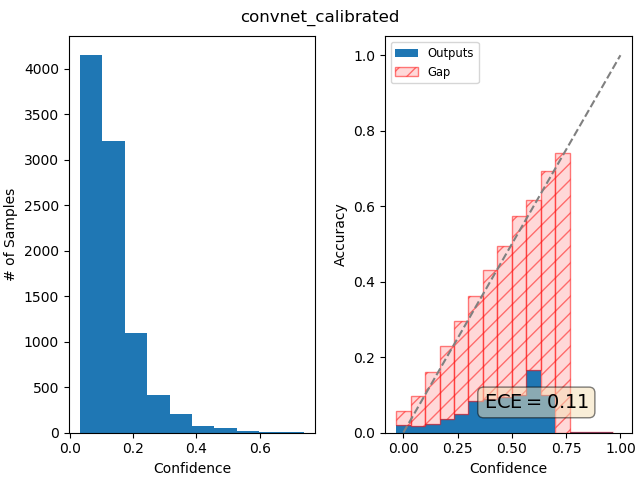
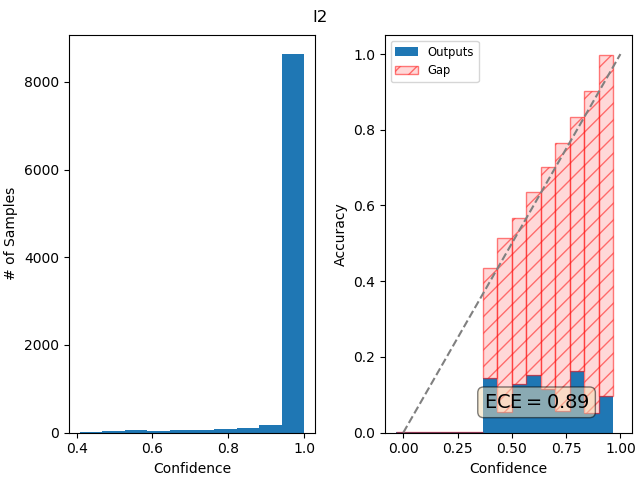
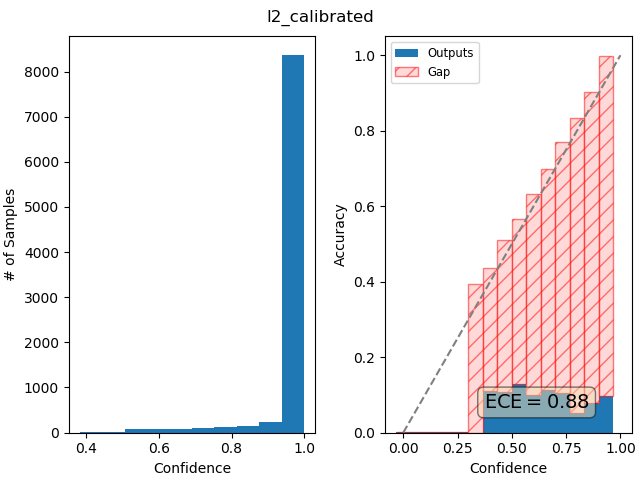
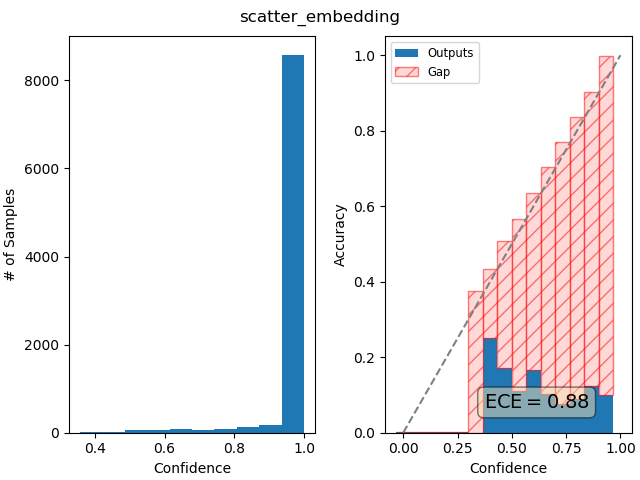
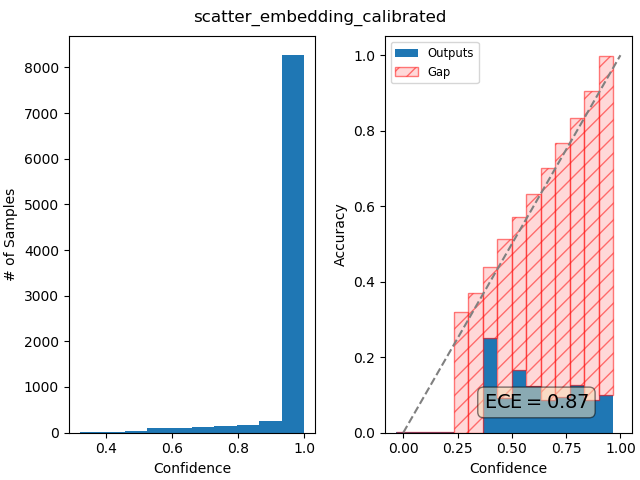
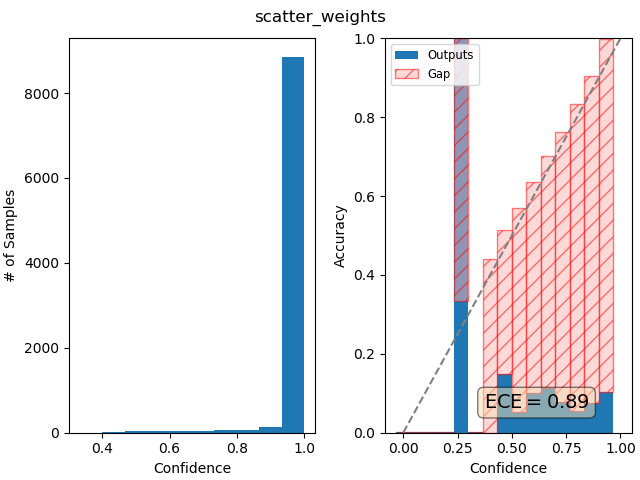
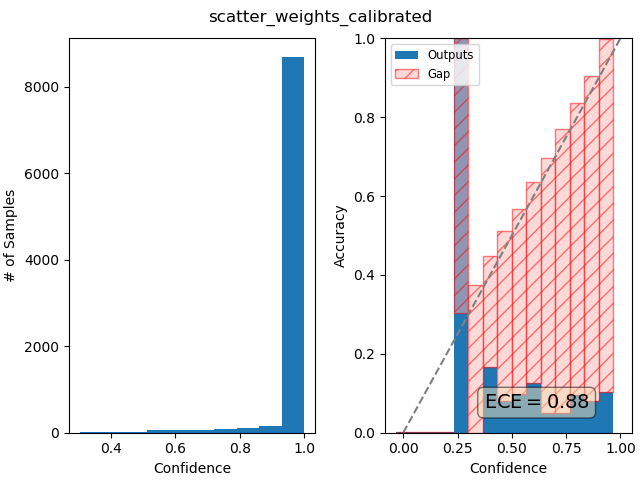
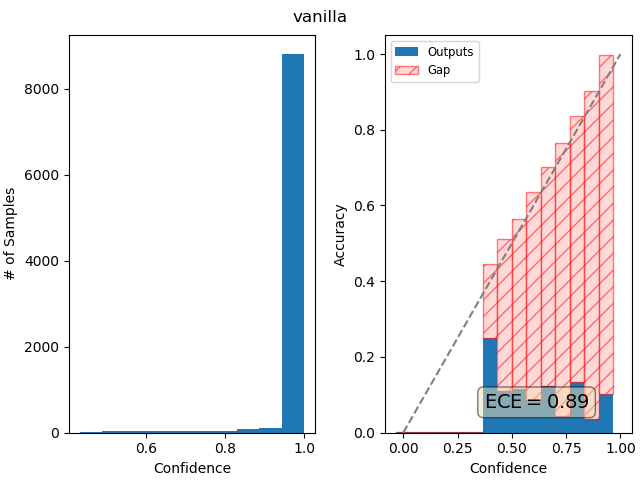
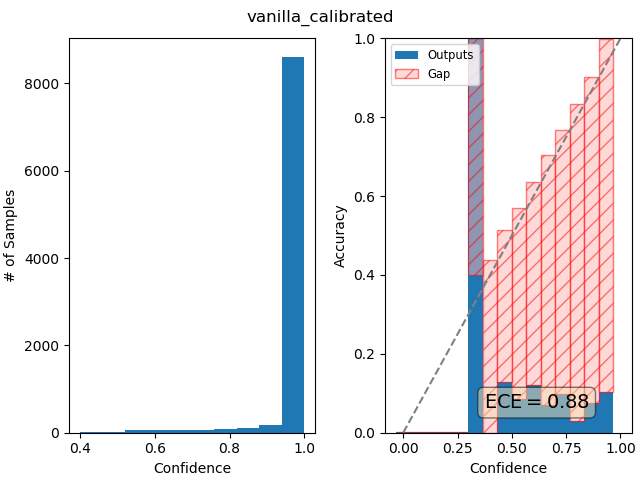
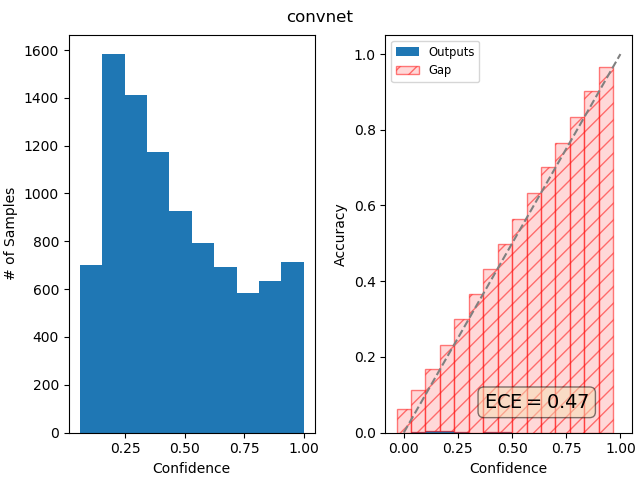
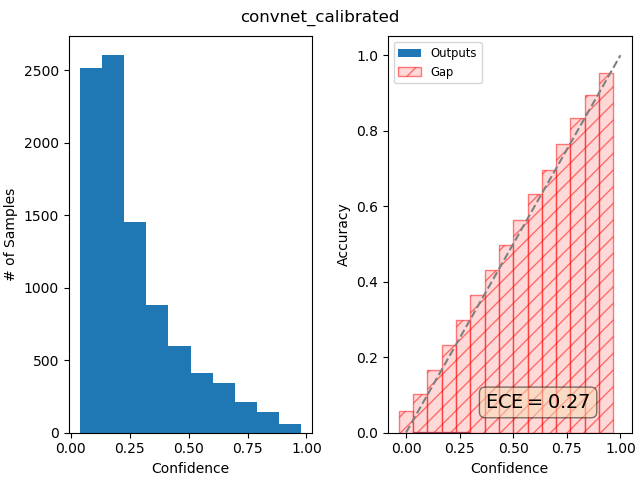
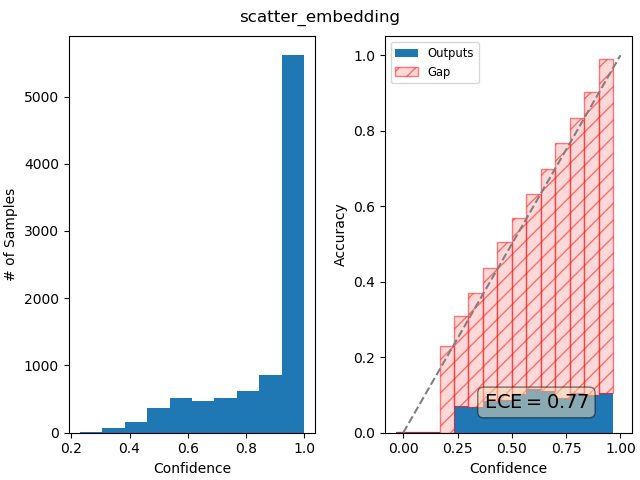
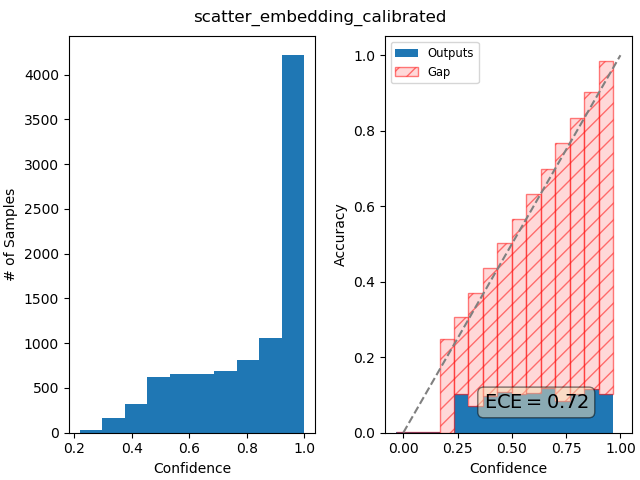
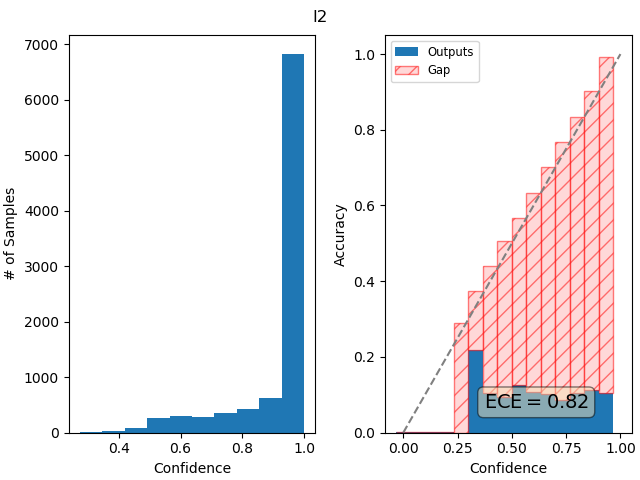
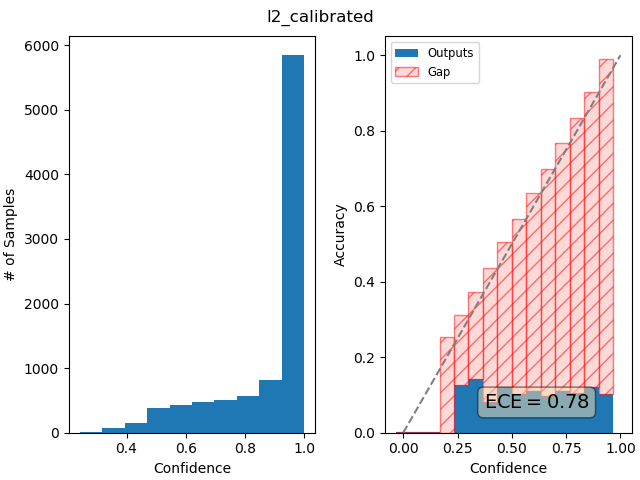
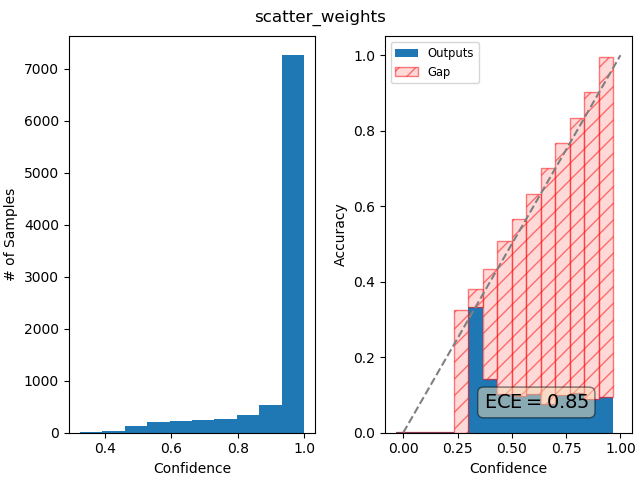
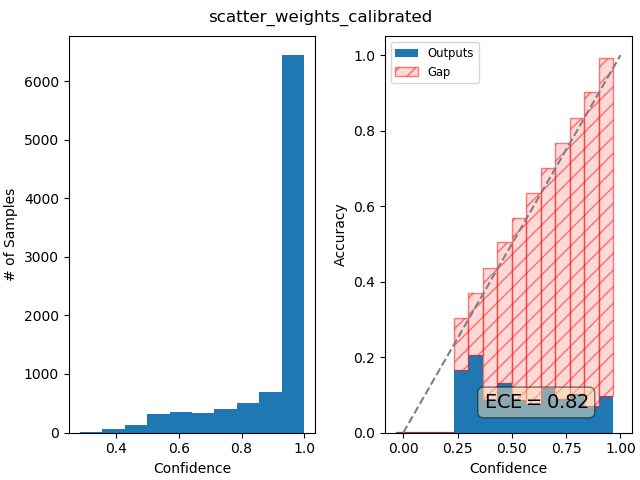
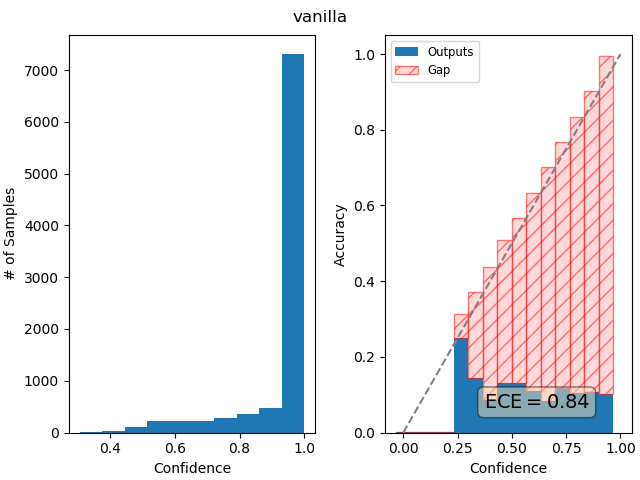
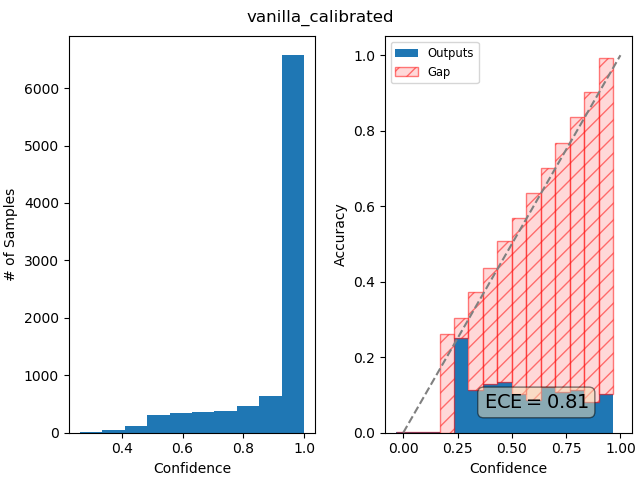

In [75]:
HTML(df_calib[['Model', 'Before', 'After']].to_html(formatters={'Before': image_formatter, 'After': image_formatter}, escape=False))

In [62]:
exper = {'Model': [], 'Before': [], 'After': []}
for idx, ex in enumerate(df_raw.experiment):
    print(ex['name'])
    gfs_artifacts = exp_artifacts_to_dict(df_raw.artifacts.iloc[idx])
    imgs_bytes_before = [fs.get(imgObj).read() for imgObj in gfs_artifacts['reliab.png']]
    imgs_bytes_after = [fs.get(imgObj).read() for imgObj in gfs_artifacts['reliab_calib.png']]
    imgs_before = [Image.open(io.BytesIO(img)) for img in imgs_bytes_before]
    imgs_after = [Image.open(io.BytesIO(img)) for img in imgs_bytes_after]
    exper['Model'].append(ex['name'])
    exper['Before'].append(imgs_before)
    exper['After'].append(imgs_after)
exper['Before'] = sum(exper['Before'], [])  # flatten nested lists
exper['After'] = sum(exper['After'], [])

circles_scatter_weights_AdamOptimizer
moons_vanilla_AdamOptimizer
circles_vanilla_AdamOptimizer
moons_scatter_weights_AdamOptimizer
circles_scatter_embedding_AdamOptimizer
moons_scatter_embedding_AdamOptimizer
circles_l2_AdamOptimizer
moons_l2_AdamOptimizer
swiss_roll_scatter_weights_AdamOptimizer
swiss_roll_l2_AdamOptimizer
swiss_roll_vanilla_AdamOptimizer
swiss_roll_scatter_embedding_AdamOptimizer
mnist_convnet_AdamOptimizer
mnist_scatter_embedding_AdamOptimizer
mnist_l2_AdamOptimizer
mnist_scatter_weights_AdamOptimizer
mnist_vanilla_AdamOptimizer
fashion_mnist_convnet_AdamOptimizer
fashion_mnist_l2_AdamOptimizer
fashion_mnist_scatter_embedding_AdamOptimizer
fashion_mnist_scatter_weights_AdamOptimizer
fashion_mnist_vanilla_AdamOptimizer
cifar10_convnet_AdamOptimizer
cifar10_scatter_embedding_AdamOptimizer
cifar10_l2_AdamOptimizer
cifar10_scatter_weights_AdamOptimizer
cifar10_vanilla_AdamOptimizer


# Evaluate data on the model

In [ ]:
# Load data
_, _, x_train, y_train, x_val, y_val, x_test, y_test = mnist_keras.prepare_data()

In [ ]:
# Evaluate model
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print('val accuracy = ', val_accuracy)

# Plot learning curves of best model

In [89]:
import matplotlib.pyplot as plt
from bson.objectid import ObjectId

def metrics_to_name_id_dict(list_metrics):
    """ Converts a list of artifacts to a dictionary of {filename:file_id}  """
    d = {}
    for metric in list_metrics:
        metric_name = metric['name']
        if metric_name in d.keys():
            raise(RuntimeError('%s metric has duplicates'%metric_name))
        d[metric_name] = ObjectId(metric['id'])
    return d    
def experiment_metrics(db, exp_id):
    ex = db.runs.find_one(dict(_id=exp_id))
    import pdb; pdb.set_trace()
    metrics_id = metrics_to_name_id_dict(ex['info']['metrics'])
    metrics = {}
    for metric, id in metrics_id.items():        
        metrics[metric] = db.metrics.find_one(dict(_id=id))
    return metrics
    
def plot_experiment_metrics(db, exp_id, metrics_to_plot=None, rename_metrics={}):
    metrics = experiment_metrics(db, exp_id)
#     import pdb; pdb.set_trace()
    if metrics_to_plot is None:
        metrics_to_plot = sorted(list(metrics.keys()))
    
    legend = []
    for name in metrics_to_plot:
        plt.plot(metrics[name]['steps'], metrics[name]['values'])
        # rename the metric if a new name is given
        legend.append(rename_metrics.get(name, name))
    return legend

In [90]:
plt.figure()
legend = plot_experiment_metrics(db, int(df_summary.index[0]), ['training.acc', 'training.loss', 'training.error'],
                                rename_metrics={'training.acc': 'Train Accuracy', 'training.loss': 'Training Loss', 'training.error': 'MSE on labels'})
plt.legend(legend);
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Training Metrics')
plt.grid(True)

plt.figure()
legend = plot_experiment_metrics(db, int(df_summary.index[0]), ['validation.acc', 'validation.loss', 'validation.error'], 
                                 rename_metrics={'validation.acc': 'Validation Accuracy', 'validation.loss': 'Validation Loss', 'validation.error': 'MSE on labels'})
plt.legend(legend, loc='center right')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Validation Metrics')
plt.grid(True)

plt.figure()
legend = plot_experiment_metrics(db, int(df_summary.index[0]), ['test.accuracy'], 
                                 rename_metrics={'test.accuracy': 'Test Accuracy'})
plt.legend(legend, loc='center right')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Test Metrics')
plt.grid(True)

FigureCanvasNbAgg()

> <ipython-input-89-cbb0751449e0>(16)experiment_metrics()
-> metrics_id = metrics_to_name_id_dict(ex['info']['metrics'])


(Pdb)  ex['info']


{'best.valid.loss': 2.070855202873645e-07, 'ckpt': './models//circles/scatter_weights/epoch_499_loss_[7.2121624e-09 7.2121624e-09 7.2121624e-09 ... 7.2121624e-09 7.2121624e-09\n 7.2121624e-09]', 'metrics': [{'id': '5c71cc8823195cb92dd11af3', 'name': 'training.acc'}, {'id': '5c71cc8823195cb92dd11af5', 'name': 'training.loss'}, {'id': '5c71cc8823195cb92dd11af7', 'name': 'training.error'}, {'id': '5c71cc8823195cb92dd11af9', 'name': 'training.reg'}, {'id': '5c71cc8823195cb92dd11afb', 'name': 'validation.acc'}, {'id': '5c71cc8823195cb92dd11afd', 'name': 'validation.loss'}, {'id': '5c71cc8823195cb92dd11aff', 'name': 'validation.error'}, {'id': '5c71cc8823195cb92dd11b01', 'name': 'validation.reg'}, {'id': '5c71cc9223195cb92dd11b92', 'name': 'test.accuracy'}]}


(Pdb)  ex['info'].keys()


dict_keys(['best.valid.loss', 'ckpt', 'metrics'])


(Pdb)  q


BdbQuit: 

# Fully delete experiements (with their artifacts) according to some query

In [ ]:
# Delete an experiement and its artifacts
def delete_experiment(experiment_id, db):
    ex = db.runs.find_one(dict(_id=experiment_id))
    
    # Delete all artifacts (file outcomes)
    for artifact in ex['artifacts']:
        fs.delete(artifact['file_id'])
        if fs.exists(artifact['file_id']):
            raise(RuntimeError('Failed to delete artifact, {}'.format(artifact)))
    
    
    # Delete all metrics
    for metric in ex['info']['metrics']:
        db.metrics.delete_one(dict(_id=metric['id']))
    
    # Delete experiment
    db.runs.delete_one(dict(_id=experiment_id))

In [ ]:
def delete_experiments_by_query(query, db):
    ids_to_delete = sacred_to_df(db.runs).query(query).index.tolist()
    for ex_id in ids_to_delete:
        delete_experiment(ex_id, db)

In [ ]:
delete_experiments_by_query('val_acc<0.85 or fc_dim<=20 or status!="COMPLETED"', db)
df_summary = sacred_to_df(db.runs).query('val_acc>0.85 and fc_dim<=100').sort_values('val_acc', ascending=False)
display(df_summary)

# Delete only model files ("artifacts") from all experiments except best 3

In [ ]:
import gridfs
def delete_artifact(name_to_delete, experiment_id, db):
    fs = gridfs.GridFS(db)
    ex = db.runs.find_one(dict(_id=experiment_id))
    updated_artifacts = []
    for i, artifact in enumerate(ex['artifacts']):
        if artifact['name'] == name_to_delete:
            fs.delete(artifact['file_id'])
            if fs.exists(artifact['file_id']):
                raise(RuntimeError('Failed to delete artifact, {}'.format(artifact)))
            else:
                # deleted successfuly, then don't add to updated_artifacts list 
                pass
        else:
            updated_artifacts.append(artifact)
    ex['artifacts'] = updated_artifacts
    db.runs.update_one({'_id':experiment_id}, {"$set": ex})

In [ ]:
# Delete all model files except of best 3 models
for ex_id in df_summary.index.tolist()[3:]:
    delete_artifact('mnist_model.h5', ex_id, db)

In [ ]:
# Show results
df_raw = query_by_df(db.runs, df_summary)
df_raw.artifacts

## Below are from previous experiment loads

# Scatter plots of penultimate layer for 1K training samples

In [ ]:
tf.reset_default_graph()
ops.reset_default_graph()
for idx, net in enumerate(network_names):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(f"./logs/checkpoints/mnist/{net}/{best_mnist_checkpoints[idx]}", clear_devices=True)
    saver.restore(sess, f"./logs/checkpoints/mnist/{net}/" + '.'.join(best_mnist_checkpoints[idx].split(".")[:-1]))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("data:0")
    penultimate = graph.get_tensor_by_name(f"{net}/layer-2/relu-l2:0")
    logits = graph.get_tensor_by_name(f"{net}/layer-3/identity-l3:0")
    probabilities = graph.get_tensor_by_name(f"{net}/layer-3/softmax_probabilities:0")
    lgts, probs, penult = sess.run([logits, probabilities, penultimate], feed_dict={x: mnist.train.images[100:1100, :]})
    sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    del sess
    nn = NeuralNetwork(mnist, net, epochs=126, batch_size=1000, dataset="mnist")
    nn.plot_scatter(penult, mnist.train.labels[100:1100].argmax(axis=1), probs.max(axis=1), epoch=0.000)
    nn.sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    del nn.sess, nn
    
    with open("{}/mnist_1.pickle".format(net), "rb") as fp:
        fig = pickle.load(fp)
        fig.show()

In [ ]:
tf.reset_default_graph()
ops.reset_default_graph()
for idx, net in enumerate(network_names):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(f"./logs/checkpoints/mnist/{net}/{best_mnist_checkpoints[idx]}", clear_devices=True)
    saver.restore(sess, f"./logs/checkpoints/mnist/{net}/" + '.'.join(best_mnist_checkpoints[idx].split(".")[:-1]))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("data:0")
    penultimate = graph.get_tensor_by_name(f"{net}/layer-2/relu-l2:0")
    logits = graph.get_tensor_by_name(f"{net}/layer-3/identity-l3:0")
    probabilities = graph.get_tensor_by_name(f"{net}/layer-3/softmax_probabilities:0")
    lgts, probs, penult = sess.run([logits, probabilities, penultimate], feed_dict={x: mnist.validation.images})
    sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    del sess
    nn = NeuralNetwork(mnist, net, epochs=126, batch_size=5000, dataset="mnist")
    nn.reliability_diagram(logits=lgts, labels=mnist.validation.labels)
    nn.set_temperature(logits=lgts, labels=mnist.validation.labels)
    nn.sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    del nn.sess, nn
    
#     with open("{}/mnist_1.pickle".format(net), "rb") as fp:
#         fig = pickle.load(fp)
#         fig.show()

In [ ]:
negloglike_before_calibration = [0.314, 0.601, 0.504, 0.486]
ece_before_calibration = [0.007, 0.035, 0.033, 0.033]
negloglike_after_calibration = [0.301, 0.433, 0.374, 0.366]
ece_after_calibration = [0.058, 0.015, 0.013, 0.014]

In [ ]:
d = {('Before Calibration','NegLogLike'): negloglike_before_calibration, ('Before Calibration','ECE'): ece_before_calibration,
     ('After Calibration','NegLogLike'): negloglike_after_calibration, ('After Calibration','ECE'): ece_after_calibration}
df = pd.DataFrame(d, index=network_names)
df

# Before calibration (based on valid dataset)

In [ ]:
for net in ["mnist_network_scatter_embedding", "mnist_network_vanilla",                                                                                                            
            "mnist_network_l2", "mnist_network_scatter_weights"]:
    with open("./logs/{}_reliab.pickle".format(net), "rb") as fp:
        fig = pickle.load(fp)
        fig.show()

# After calibration (based valid dataset)

In [ ]:
for net in ["mnist_network_scatter_embedding", "mnist_network_vanilla",                                                                                                            
            "mnist_network_l2", "mnist_network_scatter_weights"]:
    with open("./logs/{}_reliab_calib.pickle".format(net), "rb") as fp:
        fig = pickle.load(fp)
        fig.show()

## Load checkpoint with lowest validation loss

In [ ]:
d = {}
for net in network_names:
        d[net] = os.listdir(os.path.join(os.getcwd(), f"logs/checkpoints/fashion/{net}"))
df = pd.concat([pd.DataFrame([d[net] for net in network_names], index=[n for n in d])], axis=1).T
display(df)

# Caution values in the following cell should always reflect checkpoint files with lowest validation loss from the cell above

In [ ]:
best_fashion_checkpoints = []
best_fashion_checkpoints.append(df.iloc[6, 0])
best_fashion_checkpoints.append(df.iloc[9, 1])
best_fashion_checkpoints.append(df.iloc[14, 2])
best_fashion_checkpoints.append(df.iloc[10, 3])
epochs = [int(val.split("_")[1]) for val in best_mnist_checkpoints]
display(best_fashion_checkpoints)

# Load checkpointed models & recalculate stats for valid, test on mnist fashion

In [ ]:
valid_acc = []
test_acc = []
tf.reset_default_graph()
ops.reset_default_graph()
for idx, net in enumerate(network_names):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(f"./logs/checkpoints/fashion/{net}/{best_fashion_checkpoints[idx]}", clear_devices=True)
    saver.restore(sess, f"./logs/checkpoints/fashion/{net}/" + '.'.join(best_fashion_checkpoints[idx].split(".")[:-1]))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("data:0")
    y = graph.get_tensor_by_name("labels:0")
    accuracy = graph.get_tensor_by_name(f"{net}/metrics/accuracy/accuracy:0")
    val_acc = sess.run(accuracy, feed_dict={x: mnist_fashion.validation.images, y: mnist_fashion.validation.labels})
    valid_acc.append(val_acc)
    te_acc = sess.run(accuracy, feed_dict={x: mnist_fashion.test.images, y: mnist_fashion.test.labels})
    test_acc.append(te_acc)
    sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    del sess

# Stats from loaded checkpoints at best valid loss

In [ ]:
display(pd.DataFrame({'validation': valid_acc, 'test': test_acc}, index=network_names))

# Accuracy vs. Loss for (train, valid, test)

In [ ]:
with open("./logs/fashion_nets_logs.pickle", "rb") as fh:
    fashion_stats = pickle.load(fh)

tmp_network_names = []
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
test_acc = []
test_loss = []
negloglike_before_calibration = []
ece_before_calibration = []
negloglike_after_calibration = []
ece_after_calibration = []

for net_stat in fashion_stats:
    tmp_network_names.append(net_stat['title']) 
    train_acc.append(net_stat['train']['acc'][epoch])
    train_loss.append(net_stat['train']['loss'][epoch])
    valid_acc.append(net_stat['valid']['acc'][epoch])
    valid_loss.append(net_stat['valid']['loss'][epoch])
    test_acc.append(net_stat['test']['acc'][int(epoch / 25) - 1])
    test_loss.append(net_stat['test']['loss'][int(epoch / 25) - 1])
    negloglike_before_calibration.append(net_stat['calibration']['before']['NLL'])
    ece_before_calibration.append(net_stat['calibration']['before']['ECE'])
    negloglike_after_calibration.append(net_stat['calibration']['after']['NLL'])
    ece_after_calibration.append(net_stat['calibration']['after']['ECE'])

d = {('Accuracy','train'): train_acc, ('Accuracy','valid'): valid_acc, ('Accuracy','test'): test_acc,
     ('Loss','train'): train_loss, ('Loss','valid'): valid_loss, ('Loss','test'): test_loss}
df = pd.DataFrame(d, index=tmp_network_names)
del tmp_network_names
df

In [ ]:
for dset in ['fashion_train', 'fashion_valid', 'fashion_test']:
    with open("logs/{}_metrics.pickle".format(dset), "rb") as fp:
        fig = pickle.load(fp)
        fig.set_figwidth(10)
        fig.set_figheight(10)
        fig.show()

# Scatter plots of penultimate layer for 1K training samples

In [ ]:
for idx, net in enumerate(network_names):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(f"./logs/checkpoints/fashion/{net}/{best_fashion_checkpoints[idx]}", clear_devices=True)
    saver.restore(sess, f"./logs/checkpoints/fashion/{net}/" + '.'.join(best_fashion_checkpoints[idx].split(".")[:-1]))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("data:0")
    penultimate = graph.get_tensor_by_name(f"{net}/layer-2/relu-l2:0")
    logits = graph.get_tensor_by_name(f"{net}/layer-3/identity-l3:0")
    probabilities = graph.get_tensor_by_name(f"{net}/layer-3/softmax_probabilities:0")
    lgts, probs, penult = sess.run([logits, probabilities, penultimate], feed_dict={x: mnist_fashion.train.images[100:1100, :]})
    nn = NeuralNetwork(mnist_fashion, net, epochs=126, batch_size=1000, dataset="fashion")
    nn.plot_scatter(penult, mnist_fashion.train.labels[100:1100].argmax(axis=1), probs.max(axis=1), epoch=0.000)
    sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    with open("{}/fashion_1.pickle".format(net), "rb") as fp:
        fig = pickle.load(fp)
        fig.show()

# Calibration Stats

In [ ]:
tf.reset_default_graph()
ops.reset_default_graph()
for idx, net in enumerate(network_names):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(f"./logs/checkpoints/fashion/{net}/{best_fashion_checkpoints[idx]}", clear_devices=True)
    saver.restore(sess, f"./logs/checkpoints/fashion/{net}/" + '.'.join(best_fashion_checkpoints[idx].split(".")[:-1]))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("data:0")
    penultimate = graph.get_tensor_by_name(f"{net}/layer-2/relu-l2:0")
    logits = graph.get_tensor_by_name(f"{net}/layer-3/identity-l3:0")
    probabilities = graph.get_tensor_by_name(f"{net}/layer-3/softmax_probabilities:0")
    lgts, probs, penult = sess.run([logits, probabilities, penultimate], feed_dict={x: mnist_fashion.validation.images})
    sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    del sess
    nn = NeuralNetwork(mnist_fashion, net, epochs=126, batch_size=5000, dataset="fashion")
    nn.reliability_diagram(logits=lgts, labels=mnist_fashion.validation.labels)
    nn.set_temperature(logits=lgts, labels=mnist_fashion.validation.labels)
    nn.sess.close()
    tf.reset_default_graph()
    ops.reset_default_graph()
    del nn.sess, nn

In [ ]:
negloglike_before_calibration = [0.523, 0.745, 0.736, 0.728]
ece_before_calibration = [0.037, 0.068, 0.075, 0.067]
negloglike_after_calibration = [0.470, 0.570, 0.565, 0.554]
ece_after_calibration = [0.041, 0.027, 0.032, 0.028]

In [ ]:
d = {('Before Calibration','NegLogLike'): negloglike_before_calibration, ('Before Calibration','ECE'): ece_before_calibration,
     ('After Calibration','NegLogLike'): negloglike_after_calibration, ('After Calibration','ECE'): ece_after_calibration}
df = pd.DataFrame(d, index=network_names)
df

# Before calibration (based on valid dataset)

In [ ]:
for net in ["fashion_network_scatter_embedding", "fashion_network_vanilla",                                                                                                            
            "fashion_network_l2", "fashion_network_scatter_weights"]:
    with open("./logs/{}_reliab.pickle".format(net), "rb") as fp:
        fig = pickle.load(fp)
        fig.show()

# After calibration (based valid dataset)

In [ ]:
for net in ["fashion_network_scatter_embedding", "fashion_network_vanilla",                                                                                                            
            "fashion_network_l2", "fashion_network_scatter_weights"]:
    with open("./logs/{}_reliab_calib.pickle".format(net), "rb") as fp:
        fig = pickle.load(fp)
        fig.show()